<a href="https://colab.research.google.com/github/qowogks123/project_image/blob/main/image_classification_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 이미지 파일경로 불러오기

In [2]:
import os

In [3]:
IMAGE_FORMAT = {"jpeg",'jpg','png'}

def list_image_files(data_dir, sub_dir):
  image_files = []
  images_dir = os.path.join(data_dir, sub_dir)
  for file_path in os.listdir(images_dir):
    if file_path.split(".")[-1] in IMAGE_FORMAT:
      image_files.append(os.path.join(sub_dir, file_path))

  return image_files

In [7]:
data_dir ='/content/drive/MyDrive/파이널 프로젝트/data/Classification/train/'

normal_list = list_image_files(data_dir, 'Normal')
covids_list = list_image_files(data_dir, 'Covid')
pneumonias_list = list_image_files(data_dir, 'Viral Pneumonia')

print(f"Normal: {len(normal_list)}, Covid:{len(covids_list)}, Pneu:{len(pneumonias_list)}")


Normal: 70, Covid:111, Pneu:70


# 2. 이미지파일을 RGB 3차원 배열로 불러오기

In [8]:
import cv2

In [14]:
def get_RGB_image(data_dir, file_name):
  image_file = os.path.join(data_dir, file_name)
  image = cv2.imread(image_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

# 3. 이미지 데이터 확인하기

In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [12]:
min_num_files = min(len(normal_list), len(covids_list), len(pneumonias_list))
print(min_num_files)

70


In [15]:
# 슬라이드 바가 생성이 되고 바가 0부터 69번 인덱스 까지 이동할 수 있게
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
  normal_image = get_RGB_image(data_dir, normal_list[index])
  covid_image = get_RGB_image(data_dir, covids_list[index])
  pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])

  plt.figure(figsize=(12,8))
  plt.subplot(131)
  plt.title('Normal')
  plt.imshow(normal_image)

  plt.subplot(132)
  plt.title('Covid')
  plt.imshow(covid_image)

  plt.subplot(133)
  plt.title('Pneumonia')
  plt.imshow(pneumonia_image)



interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

- 정상과 코로나 환자의 image에 대해서는 구분할 수 있는 특징이 있다.
- 정상과 일반 폐럼환자의 이미지는 뚜렷하게 구분할 수 있는 특징을 찾기 힘들다.
- 각각의 이미지들이 크기가 제각각 다르다. 추후에 resize하는 부분이 필요할 것같다

# 4. 학습데이터셋 클래스 구축

 - 학습 데이터셋을 실질적으로 로드하는 클래스 구축
 - 연산 가능한 텐서 형으로 변환
 - 이터레이티브한 데이터 로더로 데이터 변환

In [35]:
import torch

In [16]:
train_data_dir = '/content/drive/MyDrive/파이널 프로젝트/data/Classification/train/'
class_list = ['Normal', 'Covid','Viral Pneumonia']

In [77]:
class Chest_dataset():
  def __init__(self, data_dir, transformer=None):
    self.data_dir = data_dir
    normals = list_image_files(data_dir, 'Normal')
    covids = list_image_files(data_dir, 'Covid')
    pneumonias = list_image_files(data_dir, 'Viral Pneumonia')

    self.files_path = normals + covids + pneumonias
    # 이미지를 tensor형태로 변환하고 agumentation기법을 적용할대 transforemr로전달
    self.transformer = transformer
  def __len__(self):
    return len(self.files_path)

  def __getitem__(self,index):
    # image와 target값 이 return 값
    image_file = os.path.join(self.data_dir, self.files_path[index])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    class_name = self.files_path[index].split(os.sep)[0]
    class_id = class_list.index(class_name)
    print(class_name, class_id)
    #print(self.data_dir, self.files_path[index])
    #print(self.files_path[index].split(os.seq))

    if self.transformer:
      image = self.transformer(image)
      class_id = torch.Tensor([class_id]).long()


    return image, class_id


In [38]:
dset = Chest_dataset(data_dir=train_data_dir)

Normal 0


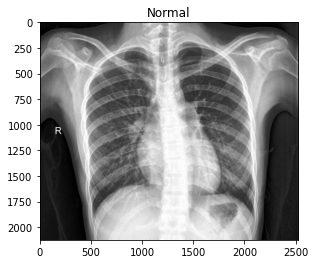

In [42]:
index = 0
image, target = dset[index]

plt.title(class_list[target])
plt.imshow(image)

In [41]:
print(image.shape)
print(target)

(2124, 2522, 3)
0


Covid 1


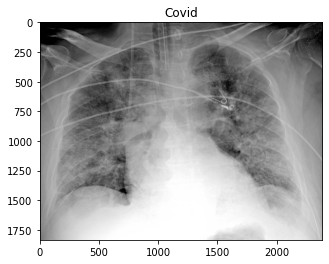

In [44]:
index = 100
image, target = dset[index]

plt.title(class_list[target])
plt.imshow(image)

In [45]:
len(dset)

251

# 5. 연산가능한 텐서형으로 데이터 변환하기

In [46]:
import torch
from torchvision import transforms


In [47]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [48]:
train_dset = Chest_dataset(train_data_dir, transformer)
index = 200
image = train_dset[index][0]
target = train_dset[index][1]
print(image.shape)
print(target)

Viral Pneumonia 2
Viral Pneumonia 2
torch.Size([3, 224, 224])
tensor([1])


# 6. 데이터로더 구현하기

In [49]:
from torch.utils.data import DataLoader

In [51]:
train_data_dir = '/content/drive/MyDrive/파이널 프로젝트/data/Classification/train/'
val_data_dir = '/content/drive/MyDrive/파이널 프로젝트/data/Classification/test/'


train_dset = Chest_dataset(train_data_dir, transformer)
train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last= True)
val_dset = Chest_dataset(val_data_dir, transformer)
val_dset = DataLoader(val_dset, batch_size=1, shuffle=False)


In [52]:
def build_dataloader(train_data_dir, val_data_dir):
  dataloaders = {}
  train_dset = Chest_dataset(train_data_dir, transformer)
  dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last= True)
  val_dset = Chest_dataset(val_data_dir, transformer)
  dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False)
  return dataloaders

In [53]:
train_data_dir = '/content/drive/MyDrive/파이널 프로젝트/data/Classification/train/'
val_data_dir = '/content/drive/MyDrive/파이널 프로젝트/data/Classification/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1aaff80190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1a32f2a190>}


# 7. VGG19 모델 불러오기 - Classification

In [54]:
from torchvision import models

In [55]:
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [56]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [57]:
from torchsummary import summary

summary(model, (3,244,244), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 244, 244]           1,792
              ReLU-2          [1, 64, 244, 244]               0
            Conv2d-3          [1, 64, 244, 244]          36,928
              ReLU-4          [1, 64, 244, 244]               0
         MaxPool2d-5          [1, 64, 122, 122]               0
            Conv2d-6         [1, 128, 122, 122]          73,856
              ReLU-7         [1, 128, 122, 122]               0
            Conv2d-8         [1, 128, 122, 122]         147,584
              ReLU-9         [1, 128, 122, 122]               0
        MaxPool2d-10           [1, 128, 61, 61]               0
           Conv2d-11           [1, 256, 61, 61]         295,168
             ReLU-12           [1, 256, 61, 61]               0
           Conv2d-13           [1, 256, 61, 61]         590,080
             ReLU-14           [1, 256,

# 8. 데이터에 맞도록 모델 Head 부분 변경하기

In [59]:
# layer을 작성하거나 layer를 수정할대 사용하는 모듈
import torch.nn as nn

In [79]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
   # nn.Dropout(0.1),
    nn.Linear(256,3),
   # nn.Sigmoid()
)

In [78]:
def build_vgg19_based_model(device='gpu'):
  device = torch.device(device)
  model = models.vgg19(pretrained=True)
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256,3),
    nn.Softmax(dim=1)
  )

  return model.to(device)
  # 작성된 cpu로 지정된 device에 마운트 
  # 이 모델이 cpu로 통해 연산을 수행할 수 있도록 gpu연산이 수행가능하도록


In [64]:
model = build_vgg19_based_model(device='cpu')

In [67]:
summary(model, (3,244,244), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 244, 244]           1,792
              ReLU-2          [1, 64, 244, 244]               0
            Conv2d-3          [1, 64, 244, 244]          36,928
              ReLU-4          [1, 64, 244, 244]               0
         MaxPool2d-5          [1, 64, 122, 122]               0
            Conv2d-6         [1, 128, 122, 122]          73,856
              ReLU-7         [1, 128, 122, 122]               0
            Conv2d-8         [1, 128, 122, 122]         147,584
              ReLU-9         [1, 128, 122, 122]               0
        MaxPool2d-10           [1, 128, 61, 61]               0
           Conv2d-11           [1, 256, 61, 61]         295,168
             ReLU-12           [1, 256, 61, 61]               0
           Conv2d-13           [1, 256, 61, 61]         590,080
             ReLU-14           [1, 256,

# 9. 손실함수(Cross-Entropy) 불러오기

In [68]:
# reduction의 의미는 mini_batch에 따라서
loss_func = nn.CrossEntropyLoss(reduction="mean")

# 10. SGDM 최적화 기법 적용하기

In [69]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.9)

# 11. 모델 학습을 위한 함수 구현하기

In [72]:
device = torch.device('cpu')

In [75]:
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
  losses = {}

  for phase in ['train','val']:
    running_loss = 0.0
    if phase == 'train':
      model.train()
    else:
      model.eval()
    
    for index, batch in enumerate(dataloaders[phase]):
      image = batch[0].to(device)
      label = batch[1].to(device)

      with torch.set_grad_enabled(phase == 'train'):
        prediction = model(image)
        loss = loss_func(prediction, target)

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      running_loss += loss.item()

      if phase == 'train':
        if index%10 == 0:
          print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")

    losses[phase] = running_loss / len(dataloaders[phase])

  return losses

# 12. 모델 검증을 위한 Accuracy 생성하기

 top-1 accuracy
  - 가장 confidence가 높은 예측값의 클래스가 ground truth와 일치하는 경우 TP로 판단

In [76]:
@torch.no_grad()
def get_accuracy(image, target , model):
  batch_size = image.shape[0]
  prediction = model(image) # (B, NUM_CLASSES)
  _, pred_label = torch.max(prediction, dim=1) # (B, 1) -> predict_label : 2 
  is_correct = (pred_label == target) # True/False
  accuracy = is_correct.cpu().numpy().sum() / batch_size
  return accuracy 

# 13. 모델 학습 수행하기

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_dir = "/content/drive/MyDrive/파이널 프로젝트/data/Classification/train/"
val_data_dir = '/content/drive/MyDrive/파이널 프로젝트/data/Classification/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device= device)
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_correct = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            image = batch[0].to(device)
            target = batch[1].squeeze(dim=1).to(device)

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                optimizer.zero_grad()

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
            
        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
    return losses, accuracies

In [88]:
num_epochs = 10

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_accuracy.append(accuracies["train"])
    val_accuracy.append(accuracies["val"])
    
    print(f"{epoch}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")
    
    if accuracies['val'] > best_acc:
      best_acc = accuracies['val']
      torch.save(model.state_dict(), f"model_{epoch}.pth")
      

Normal 0
Covid 1
Viral Pneumonia 2
Covid 1
0/62 - Running loss: 1.082404375076294
Covid 1
Viral Pneumonia 2
Covid 1
Covid 1
Normal 0
Viral Pneumonia 2
Covid 1
Normal 0
Covid 1
Covid 1
Viral Pneumonia 2
Normal 0
Viral Pneumonia 2
Normal 0
Viral Pneumonia 2
Covid 1
Viral Pneumonia 2
Viral Pneumonia 2
Covid 1
Covid 1
Viral Pneumonia 2
Covid 1
Normal 0
Covid 1
Covid 1
Viral Pneumonia 2
Covid 1
Covid 1
Normal 0
Viral Pneumonia 2
Viral Pneumonia 2
Covid 1
Covid 1
Normal 0
Viral Pneumonia 2
Covid 1
Covid 1
Covid 1
Viral Pneumonia 2
Covid 1
10/62 - Running loss: 1.0621742010116577
Viral Pneumonia 2
Covid 1
Viral Pneumonia 2
Viral Pneumonia 2
Viral Pneumonia 2
Covid 1
Covid 1
Covid 1
Covid 1
Normal 0
Normal 0
Covid 1
Covid 1
Viral Pneumonia 2
Normal 0
Covid 1
Viral Pneumonia 2
Covid 1
Viral Pneumonia 2
Normal 0
Normal 0
Viral Pneumonia 2
Normal 0
Covid 1
Normal 0
Normal 0
Covid 1
Covid 1
Normal 0
Covid 1
Normal 0
Normal 0
Normal 0
Normal 0
Normal 0
Covid 1
Viral Pneumonia 2
Covid 1
Covid 1
Vira

# 14. 테스트 이미지를 통한 학습모델 분류성능 검증하기

In [89]:
data_data = "/content/drive/MyDrive/파이널 프로젝트/data/Classification/test/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

test_normals_list = list_image_files(data_dir, "Normal")
test_covids_list = list_image_files(data_dir, "Covid")
test_pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [90]:
# 텐서형으로 변환 
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 244)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
    ])
    
    tensor_image = transformer(image)  # (C, H, W)
    tensor_image = tensor_image.unsqueeze(0) # (B, C, H, W)
    return tensor_image

In [91]:
@torch.no_grad()
def model_predict(image, model):
  tensor_image = preprocess_image(image)
  prediction = model(tensor_image)
  _, pred_label = torch.max(prediction.detach().cpu(), dim=1) # (B, NUM_CLASSEs)
  pred_label = pred_label.squeeze(dim=0) # (B,1) -> (1)
  return pred_label.item() # torch변수가 갖고 있는 수치적인 값만 가지고 온다

In [93]:
ckpt = torch.load("/content/model_7.pth")

model = build_vgg19_based_model(device='cpu')
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [95]:
model.load_state_dict(ckpt)

<All keys matched successfully>

In [94]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f"Pred:{class_list[prediction_1]} | GT:Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title(f"Pred:{class_list[prediction_2]} | GT:Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title(f"Pred:{class_list[prediction_3]} | GT:Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…